# Business Understanding

We are to make a function that will predict the best price given a customer's needs: number of bedrooms and bathrooms, square footage, location, etc.


# Data Understanding and exploration
We are to use king county housing sales data to build the model for our predictions. The file has been provided in .CSV format

In [1]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

from pandasql import sqldf
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

#initial setup for plt
plt.style.use('bmh')

#set up our sql variables
pysqldf = lambda q: sqldf(q, globals())

Read the CSV file into a pandas dataframe and inspect unique values of two perhaps comparable columns

In [2]:
df = pd.read_csv('kc_house_data.csv')
print(df.condition.unique())
print(df.grade.unique())

[3 5 4 1 2]
[ 7  6  8 11  9  5 10 12  4  3 13]


Examine the first few rows

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


When performing multivariable regression, it's important to have as little multicolinearity as possible. Colinear predictors won't affect the ultimate efficacy of the model, but it can throw the weights of individual predictors out of whack, so it's best to be aware of how things correlate to each other, and if there's a strong enough correlation there may be colinearity

In [4]:
df.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


Let's see the low end of our price column (target variable)

In [5]:
df.price.sort_values().head()

15279    78000.0
465      80000.0
16184    81000.0
8267     82000.0
2139     82500.0
Name: price, dtype: float64

Let's also make sure there are no missing values in the price column

In [6]:
df.price.isna().sum()

0

Common knowledge says square footage plays a big role in predicting a home price, so let's take a look

In [7]:
#check out just the square foot living column
df.sqft_living.describe()

count    21597.000000
mean      2080.321850
std        918.106125
min        370.000000
25%       1430.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

## Locations at a glance

Where are these homes located?
Below we make a heatmap of home locations by latitude and longitude, as well as representing the price per square foot by the color intensity

In [79]:
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm

s = df.loc[:, ['lat', 'long', 'price', 'sqft_living']]
s['price_sqft'] = df['price'] / df['sqft_living']

data=s.loc[:, ['lat', 'long', 'price_sqft']]

mapp = folium.Map(location=[47.1,
                           -121.7868], 
                 zoom_start=10,
                 width=1600, height=1600)

heat_df = data[['lat', 'long', 'price_sqft']]

# List comprehension to make out list of lists
heat_data = [[row['lat'],row['long']] for index, row in heat_df.iterrows()]

# Plot it on the map
plugins.HeatMap(heat_data, radius=10).add_to(mapp)
# mapp.fit_bounds(mapp.get_bounds())

mapp

While we're at it lets look at home sales by location as well. Again, color intensity representing price per square foot

Text(0, 0.5, 'latitude')

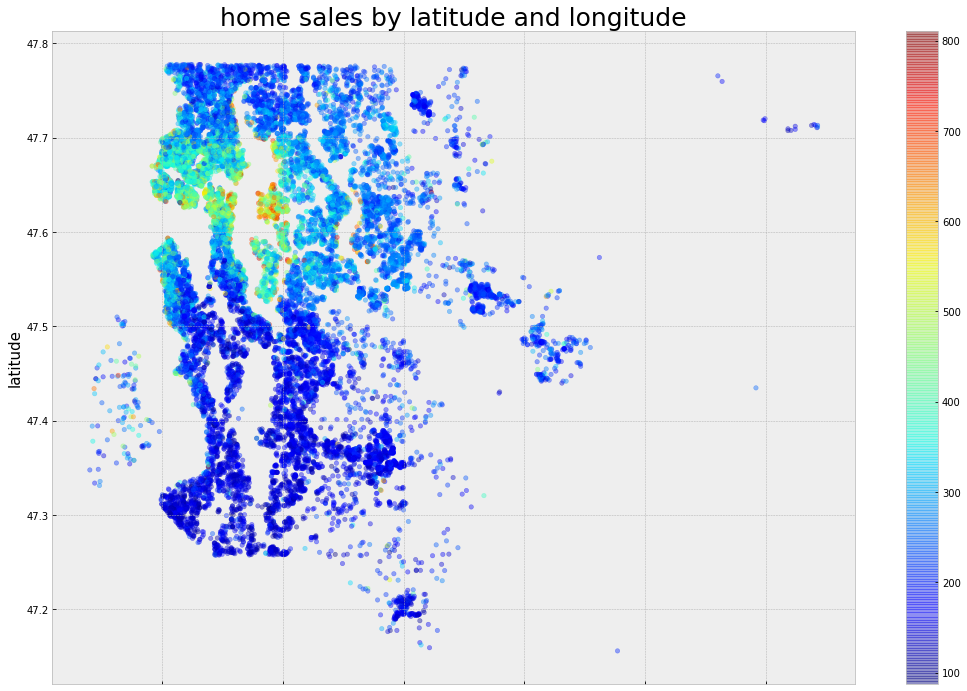

In [80]:
_ = df.plot(kind='scatter', x='long', y='lat', 
            c=df['price']/df['sqft_living'], 
            cmap=plt.get_cmap("jet"), 
            colorbar=True,
            alpha=0.4, 
            figsize=(18, 12))
plt.title('home sales by latitude and longitude', fontsize=25)
plt.ylabel('latitude',fontsize=15)


# Our first model:
square footage of living space has a high correlation to price, plus intuitively it makes sense to start the model here

In [82]:
#set some variables for our regression
X = df.sqft_living
y = df.price

In [83]:
slope, intercept, rvalue, pvalue, stderr = linregress(X,y)
first_model_y = slope*X + intercept

Let's take a look at the values of our least squares regression

In [84]:
slope, intercept, rvalue, pvalue, stderr

(280.8630143588746,
 -43988.892194227315,
 0.7019173021377599,
 0.0,
 1.9394099144299841)

Let's see what it looks like plotted against our data

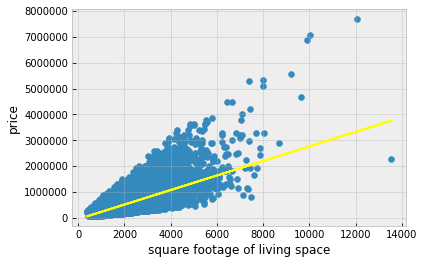

In [16]:
plt.scatter(X, y)
plt.plot(X,first_model_y,color='yellow')
plt.xlabel('square footage of living space')
plt.ylabel('price')
plt.show()

# Data preperation and cleaning


Next let's check for duplicate entries, eliminate outliers and clean up some bad data.

In [93]:
df.duplicated().sum()

0

In [98]:
#look for extremes that could be outliers
df.price.describe(), df.price.describe().round()

(count    2.159700e+04
 mean     5.402966e+05
 std      3.673681e+05
 min      7.800000e+04
 25%      3.220000e+05
 50%      4.500000e+05
 75%      6.450000e+05
 max      7.700000e+06
 Name: price, dtype: float64, count      21597.0
 mean      540297.0
 std       367368.0
 min        78000.0
 25%       322000.0
 50%       450000.0
 75%       645000.0
 max      7700000.0
 Name: price, dtype: float64)

In [101]:
#look at the extremely large homes
df.sqft_living.sort_values().tail()

14019    7620
18462    7710
16759    7730
19842    7850
13398    7880
Name: sqft_living, dtype: int64

Get rid of very expesive or very large homes

In [102]:
remove_outliers = df.loc[(df.price >= 4500000) | (df.sqft_living >= 8000)].index

In [103]:
df = df.drop(index=remove_outliers)

Ok now let's look at the distribution of the target variable (price)

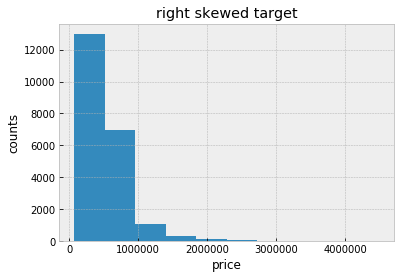

In [106]:
df.price.hist()
plt.title('right skewed target')
plt.ylabel('counts')
plt.xlabel('price')
plt.show()

Price seems pretty skewed to the right. Expressing price as it's natual logarithm should present a more normal distribution

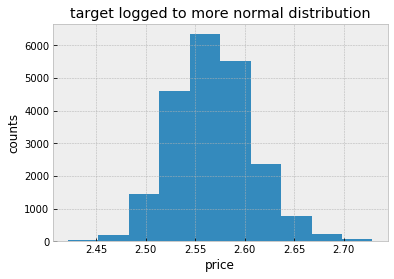

In [108]:
df.price = np.log(df.price)
df.price.hist()
plt.title('target logged to more normal distribution')
plt.ylabel('counts')
plt.xlabel('price')
plt.show()

Now let's do some janitorial work: deal with NaN values and re-express year built

In [109]:
df.view.replace(to_replace=np.NaN, value=0, inplace=True)
df.sqft_basement.replace(to_replace='?', value=0, inplace=True)
df.sqft_basement = df.sqft_basement.astype('float64')
df.waterfront.replace(to_replace=np.NaN, value=0, inplace=True)
df.yr_renovated.replace(to_replace=np.NaN, value=0, inplace=True)

In [110]:
df.yr_built = 2019 - df.yr_built
df = df.rename(columns={'yr_built': 'years_old'})

Let's see how the regression looks now that we've cleaned things up a bit

slope:  3.0429004333033813e-05 
intercept:  2.504571588935952 
r:  0.6871943210466618 
p value:  0.0 
stderr:  2.1896370945198663e-07


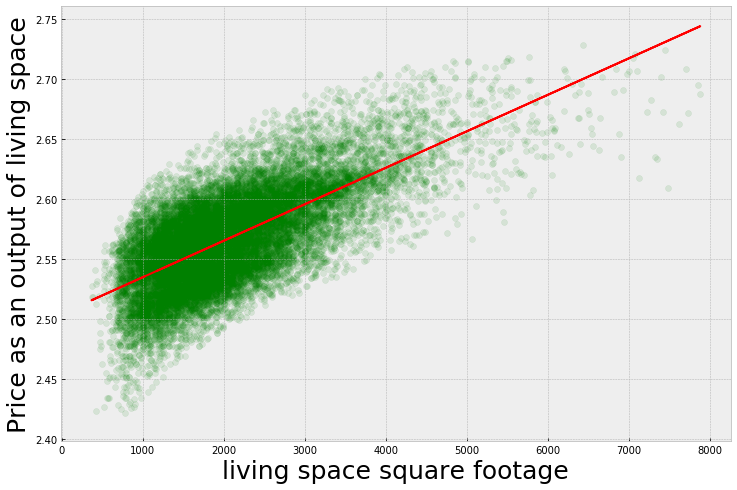

In [121]:
X = df.sqft_living
y = df.price

slope, intercept, rvalue, pvalue, stderr = linregress(X,y)

print("slope: ",
      slope,
      "\nintercept: ",
      intercept,
      "\nr: ",
      rvalue,
      "\np value: ",
      pvalue,
      "\nstderr: ",
      stderr)

first_model_y = slope*X + intercept

fig = plt.figure(figsize=(12,8))
plt.scatter(X,y, alpha=0.1, color='green')
plt.plot(X, first_model_y, color='red')
plt.xlabel('living space square footage',fontsize=25)
plt.ylabel('Price as an output of living space',fontsize=25)
plt.show()

check for multicolinearity again now that we've made our changes

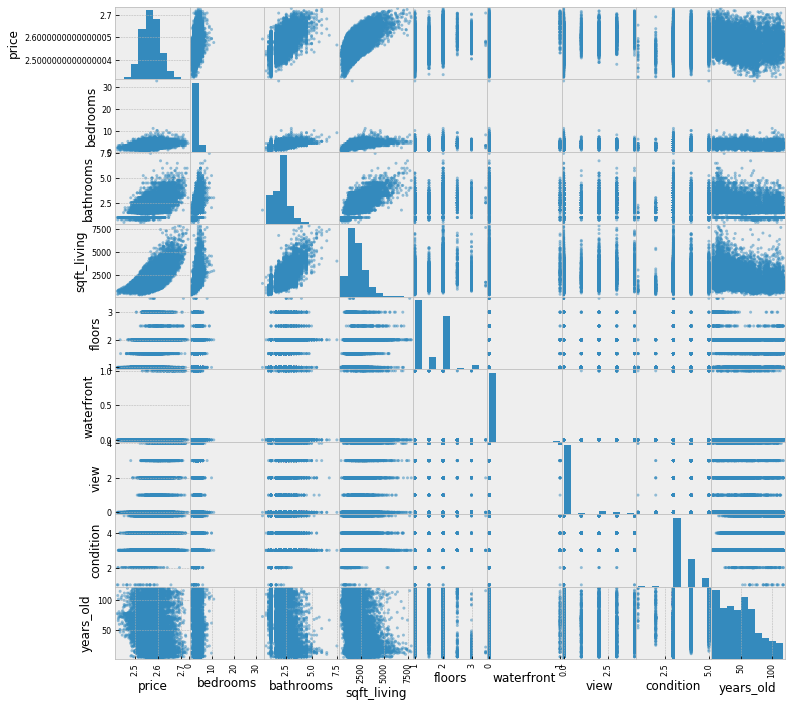

In [122]:
_ = pd.plotting.scatter_matrix(df[['price', 'bedrooms', 'bathrooms', 
                                   'sqft_living', 'floors', 'waterfront', 
                                   'view', 'condition', 'years_old']], figsize=(12, 12))

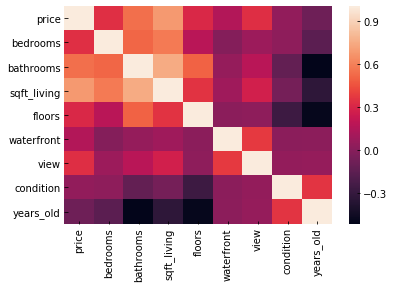

In [123]:
X = df[['price','bedrooms','bathrooms','sqft_living', 'floors', 'waterfront', 'view', 'condition', 'years_old']]
sns.heatmap(X.corr())

# Modeling
build some functions for test train splits and cross validation

In [124]:
def do_predict(X, y):
    """Perform linear regression with X and y"""
    """Return a linear regression model and model scores"""
    """Takes array like objects for X and y"""
    
    #run a train test split on our variables
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=0.2,
                                                       random_state=27)
    #perform our regression and fit
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    #set a variable to our r squared for our test set
    r2_score = lr.score(X_test, y_test)
    
    #set a variable fore adjusted r squared
    adj_r2_score = 1 - (1-r2_score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    #set a variable to our test prediction
    y_pred = lr.predict(X_test)
    
    #variable for mean squared error
    mse = mean_squared_error(y_test, y_pred)
    
    #variable for our root mean squared error
    rmse = np.sqrt(mse)
    
    #perform a cross validation with our data set
    scores = cross_val_score(lr, X, y,
                            scoring='neg_mean_squared_error', cv=10)
    
    #root mean squared error result of our cross validation
    rmse_scores = np.sqrt(-scores)
    
    #return a model & scores
    return lr, {'R2':  r2_score,
            'ADJ R2': adj_r2_score,
            'RMSE':  rmse,
            'RMSE_SCORES':   rmse_scores,
            'Mean':  rmse_scores.mean(),
            'Std':  rmse_scores.std()
            }


In [125]:
def do_validate_model(model, X, y):
    """Perform a model validation"""
    """Return a model score with X, y"""
    # get r2 value
    r2_score = model.score(X, y)
    
    #adjusted r2 value
    adj_r2_score = 1 - (1-r2_score)*(len(y)-1)/(len(y)-X.shape[1]-1)
    
    # get predict value with model
    y_pred = model.predict(X)
    
    # calculate rmse with predicted value
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    # perform a cross validation with data set
    scores = cross_val_score(model, X, y,
                            scoring='neg_mean_squared_error', cv=10)
    
    # root mean squared error result of our cross validation
    rmse_scores = np.sqrt(-scores)
    
    return {'R2':  r2_score,
            'ADJ R2': adj_r2_score,
            'RMSE':  rmse,
            'RMSE_SCORES':   rmse_scores,
            'Mean':  rmse_scores.mean(),
            'Std':  rmse_scores.std()
            }

# testing predictors
use sklearn feature ranking to pick predictors

In [126]:
#set variables for predictors and target
X = df.drop(columns=['price','date','id'])
y = df.price

In [127]:
#feature ranking with scikit learn
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 10)
selector = selector.fit(X, y)

In [128]:
#see our results
print(selector.support_)
print(selector.ranking_)

estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ True  True False False  True  True  True  True  True False False  True
 False False  True  True False False]
[1 1 3 8 1 1 1 1 1 7 6 1 5 2 1 1 4 9]
[0.00214138 0.01149484 0.00369989 0.02805934 0.00629566 0.00476924
 0.01863068 0.00032066 0.10382855 0.01294289]
-1.0015042919881978


In [129]:
#choose features based on sklearn recommendation
#and the business needs of our model
our_features = ['bedrooms','bathrooms','sqft_living','floors','grade','zipcode','lat','long','view','waterfront']

In [130]:
#set our features based on their recomendation
#and the needs of our end functions
X = df.loc[:, our_features]
y = df.price

# Evaluation
How does our model perform in general and different zip codes?


In [131]:
#how our model performs overall
model, result = do_predict(X,y)
result

{'R2': 0.7199585884553069,
 'ADJ R2': 0.7198287834068482,
 'RMSE': 0.021034047398381574,
 'RMSE_SCORES': array([0.02087604, 0.02177297, 0.02140024, 0.02094886, 0.02089123,
        0.02139613, 0.02139065, 0.02139064, 0.02110904, 0.01752609]),
 'Mean': 0.020870190376239182,
 'Std': 0.0011472177187075903}

In [132]:
#make a new column for seattle zip codes
df['Seattle_zip'] = 0

In [133]:
#funciton for seeing what zip codes are in seattle
def is_it_in_seattle(x):
    """see if a given zipcode is in Seattle"""
    seattle_zip_codes = [98101, 98102, 98104, 98105, 98108, 98109, 98112 ,98113, 98114,
                     98117, 98103, 98106, 98107, 98111, 98115, 98116, 98118, 98119,
                     98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 98122,
                     98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148,
                     98155, 98160, 98161, 98164, 98165, 98168, 98170, 98146, 98154,
                     98158, 98166, 98174, 98175, 98178, 98190, 98191, 98177, 98181,
                     98185, 98188, 98189, 98194, 98195, 98199, 98198]
    return x in seattle_zip_codes

In [134]:
#test it out
is_it_in_seattle(98101)

True

In [135]:
#set our Seattle_zip column to have true values
#if the zipcode is indeed in seattle
df.loc[df['zipcode'].apply(is_it_in_seattle) == True, 'Seattle_zip'] = 1

In [136]:
#how well does our model perform on homes only in seattle?
X = df.loc[df['Seattle_zip'] == 1, our_features]
y = df.price[df['Seattle_zip'] == 1]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.6920668211598302,
  'ADJ R2': 0.6917231073761041,
  'RMSE': 0.02071225004561146,
  'RMSE_SCORES': array([0.02057374, 0.02178719, 0.02116997, 0.02168442, 0.02071927,
         0.02159692, 0.02180444, 0.02179994, 0.02164695, 0.02065542]),
  'Mean': 0.021343826409225008,
  'Std': 0.0004874381035345548})

In [137]:
#what about only houses 'Outside' of seattle
X = df.loc[df['Seattle_zip'] == 0,our_features]
y = df.price[df['Seattle_zip'] == 0]

do_predict(X, y)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 {'R2': 0.7904205289290971,
  'ADJ R2': 0.7902542488028904,
  'RMSE': 0.018684183161903265,
  'RMSE_SCORES': array([0.0189832 , 0.01998233, 0.01974305, 0.01879792, 0.01920787,
         0.01960495, 0.01929374, 0.01933811, 0.01878146, 0.01608953]),
  'Mean': 0.01898221471048728,
  'Std': 0.0010336067266447707})

making dataframes by zipcode

In [138]:
#use sql commands to call on rows by one zipcode.
def get_dataframe_by_zip(x):
    "group home sales by their zipcode."
    q = f"SELECT * FROM df WHERE zipcode={x}"
    return pysqldf(q)
    

In [139]:
# get model by whole df
# X = df.drop(columns=['price','date','id'], axis=1)
X = df.loc[:, our_features]

y = df.price

model, result = do_predict(X, y)

In [140]:
#perform our regression on each individual
#zipcode and see how we do
zip_result = []
zipcodes = df.zipcode.unique()
zipcodes.sort()
for zipcode in zipcodes:
    zip_df = get_dataframe_by_zip(zipcode)
    
    X = zip_df.loc[:, our_features]
#     XX = zip_df.drop(columns=['price','date','id'], axis=1)
    y = zip_df.price

    result = do_validate_model(model, X, y)
    zip_result.append((zipcode, result['Mean']))


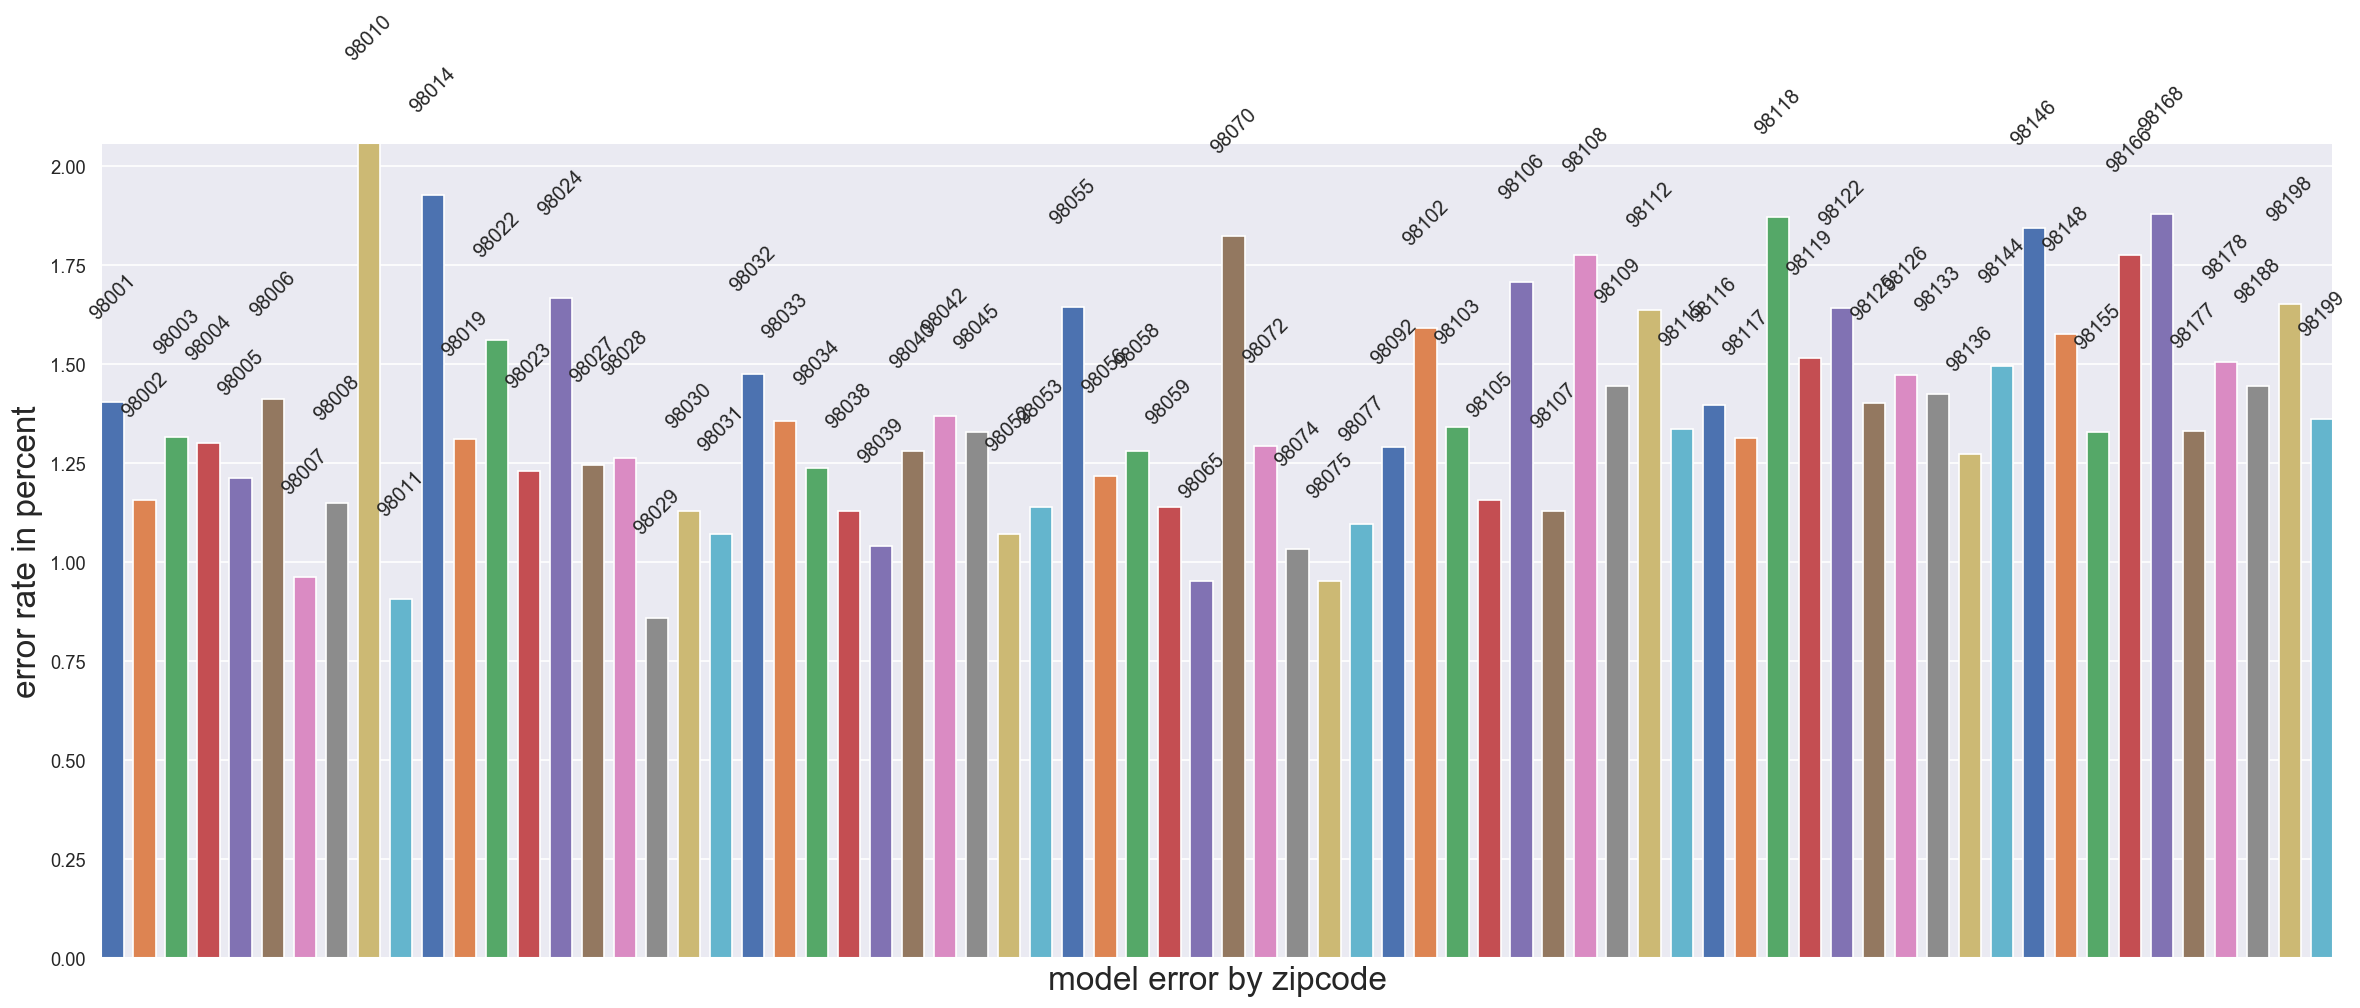

In [141]:
#plot our results
sns.set()
fig, ax = plt.subplots(figsize=(24, 9), dpi=120)

rects = ax.patches
ax.autoscale(tight=True)

zipcodes = []
rmses = []
for zipcode, mean_rmse in zip_result:
    zipcodes.append(str(zipcode))
    rmses.append(mean_rmse)
    ax.bar(str(zipcode), mean_rmse*100, width=.7)

fig.set_title = "Model fitting score by zipcode" 
# ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel('model error by zipcode', fontsize=20)
ax.set_ylabel('error rate in percent', fontsize=20)

for rect, label in zip(rects, zipcodes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .2, label,
           ha='center', va='bottom', rotation=45)

In [142]:
zip_loc_df = pd.read_csv('wa_zip_lat_lng.csv', delimiter=';')
zip_loc_df.head()

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,98063,Federal Way,WA,47.432251,-121.803388,-8,1,"47.432251, -121.803388"
1,98070,Vashon,WA,47.416198,-122.468210,-8,1,"47.416198, -122.46821"
2,98101,Seattle,WA,47.610670,-122.334380,-8,1,"47.61067, -122.33438"
3,98121,Seattle,WA,47.614870,-122.345780,-8,1,"47.61487, -122.34578"
4,98246,Bow,WA,48.558127,-121.417034,-8,1,"48.558127, -121.417034"


In [143]:
from pylab import *
from branca.colormap import linear
import branca.colormap as cm

map = folium.Map(location=[df['lat'].mean(),
                           df['long'].mean()], 
                 zoom_start=8,
                 tiles='cartodbpositron'
                )

norm = [np.linalg.norm(r) for r in rmses]

s = [a / max(rmses) for a in rmses]  # scale
# set color based on size
c = s
colors = [plt.cm.RdYlGn(color) for color in c]  # gets the RGBA values from a float
colormap = cm.linear.RdYlGn_03.scale(0, max(rmses))

for zipcode, rmse, color in zip(zipcodes, rmses, colors):
    location = zip_loc_df.loc[zip_loc_df['Zip'] == int(zipcode), ['Latitude', 'Longitude']]
    lat = location.Latitude
    lng = location.Longitude

    lat = lat.values[0]
    lng = lng.values[0]

    rgb = color[:3] # will return rgba, we take only first 3 so we get rgb
    color = str(matplotlib.colors.rgb2hex(rgb))

    marker = folium.CircleMarker(location=[lat, lng], radius=20,#1800-(rmse/1000),
                    line_color=color,
                    weight=0.,
                    fill_color=color,
                    fill_opacity=.85,
                    fill=True).add_to(map)


# folium.map.LayerControl('topright', collapsed=False).add_to(map)
import branca.colormap
colormap = colormap.to_step(6)
colormap.caption = 'Model performance by Zipcode'
colormap.add_to(map)

map.fit_bounds(map.get_bounds())
map

# Deployment
The functions below are used to make our final predictions

In [144]:
#set our variables to the final model
X = df.loc[:, our_features]
y = df.price

model, result = do_predict(X, y)
model.coef_

array([-4.35499070e-04,  1.16201179e-03,  1.67877243e-05,  1.23831091e-04,
        1.09141157e-02, -4.78730009e-05,  1.16858414e-01, -2.13387037e-02,
        6.67909995e-03,  2.70712174e-02])

In [145]:
def get_location(zipcode):
    """Pull area information based on the input zipcode"""
    location = zip_loc_df.loc[zip_loc_df['Zip'] == int(zipcode), ['Latitude', 'Longitude', 'City']]
    lat = location.Latitude
    lng = location.Longitude
    city_name = location.City

    lat = lat.values[0]
    lng = lng.values[0]
    city_name = city_name.values[0]
    
    return {
        'latitude': lat,
        'longitude': lng,
        'city_name': city_name
    }

    

In [146]:
def price_predict(model,
                  result,
                  zipcode,
                  bedrooms,
                  bathrooms,
                  square_footage,
                  floors,
                  grade,
                  view=False,
                  waterfront=False,):
    """Predict the sale price of a home"""
    grade += 3
    location = get_location(zipcode)
    
    X = [[bedrooms, bathrooms, square_footage, floors, 
         grade, zipcode, location['latitude'], location['longitude'], view, waterfront ]]
    
              
    pred_price = np.exp(model.predict(X))
    pred_low_price = pred_price - (pred_price * (result['Mean'] / 2))
    pred_high_price = pred_price + (pred_price * (result['Mean'] / 2))
    grade -=3
    result_value = {
        'predict_price': round(pred_price[0]),
        'predict_low_price': round(pred_low_price[0]),
        'predict_high_price': round(pred_high_price[0]),
        'city_name': location['city_name']
    }
    return result_value

In [147]:
price_predict(model, result, 98010, 3, 2, 1500, 0, 7)

{'predict_price': 13.0,
 'predict_low_price': 13.0,
 'predict_high_price': 13.0,
 'city_name': 'Black Diamond'}

# Conclusion

Our final model predicts home sales prices in an approximately 26% range, 13% up or down, as you can in the model output. During testing, we found that our model performed best in places like Issaquah, Snoqualmie, and Bothell, and performed worse in places like Vashon, Carnation, and Black diamond. While there's lots of things that could be improved about this model (like the fact that raising the number of bedrooms lowers prediction price, what's up with that?), we're pretty happy with it's output for only a weeks work.